In [1]:
## The web extracted corpus is read a data frame
## following 4 fucntions described here are used in phase 1 cleaning
## no stopwords are used
## only HTML junk, junk such as <>, _, !! , $, % etc is eliminated
## context of the entirea corpus is kept unchanged

## reference: https://media.readthedocs.org/pdf/gensim/stable/gensim.pdf
## https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

import re                                                        
import os 
import pandas as pd
import numpy as np
from pandas import ExcelWriter

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt


def clean_phase_1(text):
    import re                                                                                     
    if(len(text) == 0):
        text = '0'
        return text
        
    #text = re.sub(r'(\.)(I|A)\s', r'\1 \2 ' , text)
    #text = re.sub(r'(\.)([a-z|A-Z|0-9]\w+)', r'\1 \2 ' , text)
    
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\\n', ' ', text) ## remove \n as a symbol ( not a new line character)
    text = re.sub(r'(<.*?>)', ' ', text)  ## eliminate everything that falls under '< >' as HTML junk
    #text = re.sub(r'(\&|\%|\$|\.|\?|!|#)(\s|\&|\.|\%|\$|\?|!|#)*(\1+)', r' \1 ' , text)  
    text = re.sub(r'\.', ' ' , text)
    text = re.sub(r'(\&|\%|\$|\?|!|#)(\s|\&|\%|\$|\?|!|#)*(\1+)', r' \1 ' , text) 
    text = re.sub(r'(\%)', ' percent ' , text) 
    text = re.sub(r'(\$)', ' dollars ' , text)  
    text = re.sub(r'aadhar|adhar|adhaar|aaaadhaar|aaadhaar|aadar|aadaar|aaddhaar|aadahaar|aadhaaar', ' aadhaar ' , text)
    text = re.sub(r'\s+',' ', text)  
    
    replacement_patterns = [
     (r'won[\'\’\‘\"]t', ' will not '),
     (r'can[\'\’\‘\"]t', ' cannot '),
     (r'i[\'\’\‘\"]m', ' i am '),
     (r'it[\’\'\‘\"]s', ' it is '),
     (r'ain[\'\’\‘]t', ' is not '),
     (r'(\w+)[\'\’\‘\"]ll', '\g<1> will'),
     (r'(\w+)n[\'\’\‘\"]t', '\g<1> not'),
     (r'(\w+)[\'\’\‘\"]ve', '\g<1> have'),
     (r'(\w+)[\'\’\‘\"]re', '\g<1> are'),
     (r'(\w+)[\'\’\‘\"]d', '\g<1> would')]    
    

    for pattern in replacement_patterns: 
        text = re.sub (pattern[0],  pattern[1] , text)

    #text = re.sub(r'[^a-z\s\.\&]', ' ', text)
    text = re.sub(r'[^a-z\s\&]', ' ', text)


    text = re.sub(r'per cent', ' percent ' , text)
    text = re.sub(r'\s+',' ', text)
    text = re.sub("^\s+|\s+$", "", text)

    return text 


def word_count (text):
    from collections import Counter
    words_in_text = text.split()
    word_list = []
    for word in words_in_text:
        word = re.sub(r'^[^a-z0-9]+', '', word)
        word = re.sub(r'[^a-z0-9]+$', '', word)
        word = re.sub(r'\.',"" , word)

        if len(word)< 2:
            appen_d = False  
        else: 
            word_list.append(word)

    return len(word_list)

######################################################################################

def remove_stopwords(text, stopwords):  
    import re
    list_words_of_corpus =text.split()
    word_list = []
    for word in list_words_of_corpus: 
        if word not in stopwords :
            word_list.append(word)
            
    text = ' '.join(word_list) 
    
    return text

########################################################################################
import nltk
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer


def part_of_speec_tag (treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None 
        

def lemmatize(word):
    lemmatizer = WordNetLemmatizer()
    word = word_tokenize(word)
    tagged = nltk.pos_tag(word)
    
    for word, tag in tagged:
        wntag = part_of_speec_tag(tag)
        if wntag is None:
            word = lemmatizer.lemmatize(word) 
        else:
            word = lemmatizer.lemmatize(word, pos=wntag) 
    return word

global count_proc
count_proc = 0

def clean_phase_2(text): 
    global count_proc
    rem_words = ['aa', 'aaa']
    count_proc = count_proc +1
    new_lis =text.split()
    word_list = []
    for word in new_lis:
        word = re.sub(r'\s+', '', word) 
        word = re.sub(r'^[^a-z]+', '', word)
        word = re.sub(r'[^a-z]+$', '', word)
        word = re.sub(r'\scom\s|\sin\s|\snet\s', '', word)
        
        if len(word)<=4 or re.findall(r'\&', word):
            if word not in rem_words and len(word)>1:
                word_list.append(word)
        else: 
            word = lemmatize(word)
            word_list.append(word)
        
    text = ' '.join(word_list) 
    count_proc_all = [100, 500, 1000, 2000, 5000, 12000, 17000]
    if count_proc in count_proc_all:
        print(count_proc)
    return text

########################################################################################

def n_grams(df,colname, min_df, ngram_list):
    import os
    activ_dir = '/Users/anirudh_syal/Documents/1_text_analytics_002/1_Code/1_0_all_corpus/corpus_n_grams'
    os.chdir(activ_dir)
    from sklearn.feature_extraction.text import TfidfVectorizer
    a = list(df[colname])
    count = 0
    for ngram in ngram_list:
        print(ngram)
        if ngram <7:
            min_df= min_df
        else:
            min_df = 15
        ngram_range_tuple = (ngram, ngram)
        vectorizer = TfidfVectorizer(min_df=min_df, max_features=10000, ngram_range = ngram_range_tuple)
        vz = vectorizer.fit_transform(a)
        name_n_gram = 'tfidf'+'_'+str(ngram)+'.xlsx'
        tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
        tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
        tfidf.columns = ['tfidf']
        writer = pd.ExcelWriter(name_n_gram)
        tfidf.to_excel(writer, sheet_name=str(ngram))
        writer.save()
        print(len(tfidf))
        
    return tfidf

########################################################################################

def tokenizer_tf_idf(text):
    word_vector = text.split()
    return word_vector

def remove_numerals_for_topic_mining(text):
    text = re.sub(r'[^a-z\s\.\&\_\-]', ' ', text)
    text = re.sub(r'\s+',' ', text)
    
    return text


global replacement_count
replacement_count= 0
def replace_ngrams (text, bi_gram_lis,tri_gram_lis, four_gram_lis,five_gram_lis, six_gram_lis,seven_gram_lis, eight_gram_lis ):
    
    new_lis =text.split()
    ret_list = []
    i=0
    while i < len(new_lis):
        if i == len(new_lis)-1:
            ret_list.append(new_lis[i])
            i = i+1
        elif i <= len(new_lis) -8:   
            query_2 = new_lis[i] + '_' + new_lis [i+1]
            query_3 = query_2 + '_' + new_lis [i+2]
            query_4 = query_3 + '_' + new_lis [i+3]
            query_5 = query_4 + '_' + new_lis [i+4]
            query_6 = query_5 + '_' + new_lis [i+5]
            query_7 = query_6 + '_' + new_lis [i+6]
            query_8 = query_7 + '_' + new_lis [i+7]
            
            if query_8 in eight_gram_lis:
                ret_list.append(query_8)
                i = i+8
                print(query_8)
            if query_7 in seven_gram_lis:
                #print(query_7)
                ret_list.append(query_7)
                i = i+7 
            elif query_6 in six_gram_lis:
                #print(query_6)
                ret_list.append(query_6)
                i = i+6
            elif query_5 in five_gram_lis:
                #print(query_5)
                ret_list.append(query_5)
                i = i+5
            elif query_4 in four_gram_lis:
                #print(query_4)
                ret_list.append(query_4)
                i = i+4
            elif query_3 in tri_gram_lis:
                #print(query_3)
                ret_list.append(query_3)
                i = i+3
            elif query_2 in bi_gram_lis:
                #print(query_2)
                ret_list.append(query_2)
                i = i+2
            else:
                ret_list.append(new_lis[i])
                i=i+1     
        
        elif i == len(new_lis) -7: 
            query_2 = new_lis[i] + '_' + new_lis [i+1]
            query_3 = query_2 + '_' + new_lis [i+2]
            query_4 = query_3 + '_' + new_lis [i+3]
            query_5 = query_4 + '_' + new_lis [i+4]
            query_6 = query_5 + '_' + new_lis [i+5]
            query_7 = query_6 + '_' + new_lis [i+6]
            
            if query_7 in seven_gram_lis:
                #print(query_7)
                ret_list.append(query_7)
                i = i+7 
            elif query_6 in six_gram_lis:
                #print(query_6)
                ret_list.append(query_6)
                i = i+6
            elif query_5 in five_gram_lis:
                #print(query_5)
                ret_list.append(query_5)
                i = i+5
            elif query_4 in four_gram_lis:
                #print(query_4)
                ret_list.append(query_4)
                i = i+4
            elif query_3 in tri_gram_lis:
                #print(query_3)
                ret_list.append(query_3)
                i = i+3
            elif query_2 in bi_gram_lis:
                #print(query_2)
                ret_list.append(query_2)
                i = i+2
            else:
                ret_list.append(new_lis[i])
                i=i+1     

        elif i == len(new_lis) -6: 
            query_2 = new_lis[i] + '_' + new_lis [i+1]
            query_3 = query_2 + '_' + new_lis [i+2]
            query_4 = query_3 + '_' + new_lis [i+3]
            query_5 = query_4 + '_' + new_lis [i+4]
            query_6 = query_5 + '_' + new_lis [i+5]
            if query_6 in six_gram_lis:
                print(query_6)
                ret_list.append(query_6)
                i = i+6
            elif query_5 in five_gram_lis:
                print(query_5)
                ret_list.append(query_5)
                i = i+5
            elif query_4 in four_gram_lis:
                #print(query_4)
                ret_list.append(query_4)
                i = i+4
            elif query_3 in tri_gram_lis:
                #print(query_3)
                ret_list.append(query_3)
                i = i+3
            elif query_2 in bi_gram_lis:
                #print(query_2)
                ret_list.append(query_2)
                i = i+2
            else:
                ret_list.append(new_lis[i])
                i=i+1     

        elif i == len(new_lis) -5: 
            query_2 = new_lis[i] + '_' + new_lis [i+1]
            query_3 = query_2 + '_' + new_lis [i+2]
            query_4 = query_3 + '_' + new_lis [i+3]
            query_5 = query_4 + '_' + new_lis [i+4]

            if query_5 in five_gram_lis:
                #print(query_5)
                ret_list.append(query_5)
                i = i+5
            elif query_4 in four_gram_lis:
                #print(query_4)
                ret_list.append(query_4)
                i = i+4
            elif query_3 in tri_gram_lis:
                #print(query_3)
                ret_list.append(query_3)
                i = i+3
            elif query_2 in bi_gram_lis:
                #print(query_2)
                ret_list.append(query_2)
                i = i+2
            else:
                ret_list.append(new_lis[i])
                i=i+1     

        elif i == len(new_lis) -4: 
            query_2 = new_lis[i] + '_' + new_lis [i+1]
            query_3 = query_2 + '_' + new_lis [i+2]
            query_4 = query_3 + '_' + new_lis [i+3]

            if query_4 in four_gram_lis:
                #print(query_4)
                ret_list.append(query_4)
                i = i+4
            elif query_3 in tri_gram_lis:
                #print(query_3)
                ret_list.append(query_3)
                i = i+3
            elif query_2 in bi_gram_lis:
               # print(query_2)
                ret_list.append(query_2)
                i = i+2
            else:
                ret_list.append(new_lis[i])
                i=i+1     

        elif i == len(new_lis) -3: 
            query_2 = new_lis[i] + '_' + new_lis [i+1]
            query_3 = query_2 + '_' + new_lis [i+2]
            if query_3 in tri_gram_lis:
                #print(query_3)
                ret_list.append(query_3)
                i = i+3
            elif query_2 in bi_gram_lis:
               # print(query_2)
                ret_list.append(query_2)
                i = i+2
            else:
                ret_list.append(new_lis[i])
                i=i+1     

        elif i == len(new_lis) -2: 
            query_2 = new_lis[i] + '_' + new_lis [i+1]
            if query_2 in bi_gram_lis:
                #print(query_2)
                ret_list.append(query_2)
                i = i+2
            else:
                ret_list.append(new_lis[i])
                i=i+1     

    text = ' '.join(ret_list) 

    return text





In [2]:
## phase 1 clean
## these columns are type cast to string format below
import pandas as pd
news_df = pd.read_excel('corpus_df_002.xlsx')
news_df['newsbody_original'] = news_df['newsbody_original'].astype(str)   ## convert all columns to string format for later use
news_df['heading'] = news_df['heading'].astype(str)   ## convert all columns to string format for later use
news_df.drop_duplicates(inplace = True) ## drop all apparent duplicates
news_df['article_length'] = news_df['newsbody_original'].apply(word_count)


In [ ]:
def tag_cosine_similar_duplicates (df, col_name, cosine_similarity_cut_off):
    df['doc_no'] = range(len(df))
    df['doc_no'] = df['doc_no'] + 1
    from sklearn.feature_extraction.text import CountVectorizer
    import datetime
    df_before_op = len(df)
    ## convert news body column into a collection of text in a list format
    text_to_list = df[col_name].tolist()
    vect = CountVectorizer()
    ##  develop a bag of words model
    ##  vect.fit learns the vocabulary in corpus to develop a term frequency matrix
    vect.fit(text_to_list)
    dtm = vect.transform(text_to_list)
    ## convert the BOW model to an N X M matrix. ( N is the no of diff articles, M is the unique corpus words)
    ## any entry i,j in dtm_matrix corresponds to the no of words of type | lable 'j' in article no i
    dtm_matrix = dtm.toarray()
    ## import handy cosine similarity ( X*XT)
    from sklearn.metrics.pairwise import cosine_similarity
    similarity  = cosine_similarity(dtm_matrix, dtm_matrix)
    iters = similarity.shape
    iter_max = iters[0]
    ## initialize the list of entries that are cosine repeated and to be eliminated in the corpus
    remove = []
    keep =   []
    ## iterate only on 1st half non diagonal elements of the matrix ( matrix is symmetric)
    for i in range (1, iter_max):
        if i not in remove:
            for j in range(i+1,iter_max):
                if j not in remove:
                    if similarity [i,j] >cosine_similarity_cut_off:
                        remove.append(j) ## doc_to_remove_list
                        keep.append(i) ## doc_to_keep_list

    ## get unique entries only , convert to a dataframe,tag as remove_is_true  
    remove_df = pd.DataFrame(list(zip(remove, keep)),
                  columns=['doc_no','doc_keep'])

    remove_df['remove_is_true'] = 1
    df = pd.merge(df, remove_df, how='left', on=['doc_no'])
    df_after_merge_1 =  len(df)
    #print('change in length = ', df_after_merge_1 - df_before_op)
    df['remove_is_true'] = np.where(df['remove_is_true']==1,1,0)

    df_to_merge = df[['doc_no', 'dateTime', 'publication']].copy()
    #print('change_in_length_new = ', df_after_merge_1 - len(df_to_merge ))

    df_to_merge.rename(columns = {'doc_no':'doc_keep', 'dateTime': 'dt', 'publication' : 'ref_publication'}, inplace = True)
    df = pd.merge(df, df_to_merge, how='left', on=['doc_keep'])
    #print('change_in_length_after_merge_new', len(df) -  df_after_merge_1 )

    df['days_diff'] = (df['dateTime'] - df ['dt']).dt.days
    df['same_pub'] = df['publication'] - df ['ref_publication']
    df['same_pub'] =  np.where(df['same_pub']==0,1,df['same_pub'])
    df['remove_is_true'] =  np.where(df['days_diff']*df['same_pub'] <=4,1,0)
    df.drop(['doc_no','dt', 'same_pub', 'days_diff', 'ref_publication' ], axis = 1, inplace = True)
    #print('change_in_return_length' , len(df) -  df_after_merge_1 )

    return df

for publication in range (1, news_df.publication.max() +1):
#for publication in range (1, 3):
    print('=====================================================================================')
    print('publication =' , publication)
    test_df = news_df[news_df['publication']==publication].copy()
    check_1 = len(test_df)
    test_df= tag_cosine_similar_duplicates(test_df,'newsbody_original', 0.95) 
    print ('len_after_dup_tag =',check_1- len(test_df))
    if publication == 1:
        concact_df = test_df.copy()
    else:
        frames = [concact_df, test_df]
        inter = len(concact_df) + len(test_df)
        concact_df = pd.concat(frames)
        print('publication =' ,publication,'check_4 =' , len(concact_df)-inter )

news_df = concact_df.copy(deep=True)
del(concact_df)
news_df.head()
print(len(news_df))
news_df = news_df[news_df['remove_is_true']==0].copy(deep=True)
print(len(news_df))

news_df.drop(['remove_is_true'], axis = 1, inplace = True)
writer = pd.ExcelWriter('news_df_rm_dup_001.xlsx', engine='xlsxwriter',options={'strings_to_urls': False})
news_df.to_excel(writer)
writer.save()
writer.close()

for publication in range (1, news_df.publication.max() +1):
    print(publication, news_df[news_df['publication'] == publication].dateTime.min())
    
    

In [3]:
###====== re - cleaning

active_dir = "/Users/anirudh_syal/Documents/1_text_analytics_002/1_Code/1_0_all_corpus"
os.chdir (active_dir )

news_df = pd.read_excel('/Users/anirudh_syal/Documents/1_text_analytics_002/1_Code/1_0_all_corpus/news_df_rm_dup_001.xlsx')
news_df['doc_no'] = range(len(news_df))
news_df['doc_no'] = news_df['doc_no'] + 1

def clean_more_1(text):
    string = 'Documents not an issue anymore! These nations welcome Indians without a Visa'
    if text.startswith(string):
        text = re.sub(string," ",text) 
    
    return text 

news_df['newsbody_original'] = news_df['newsbody_original'].apply(clean_more_1)

n = news_df[news_df['publication']==5].copy()
n.head()
def clean_more_2(text):
    text = re.sub(r'[a-zA-Z][A-Za-z0-9_%+-]+\.[A-Za-z0-9_%+-]+@thehindu.co.in'," ",text) 
    
    return text 

news_df['newsbody_original'] = news_df['newsbody_original'].apply(clean_more_2)

## publication = 4

def clean_more_3(text):
    text = re.sub(r'Published by HT.*'," ",text) 
    
    return text 

news_df['newsbody_original'] = news_df['newsbody_original'].apply(clean_more_3)

## publication = 4

def clean_more_4(text):
    text = re.sub(r'^[0-9]+-[0-9]+-[0-9]+[a-zA-Z0-9\s\,\.]+--'," ",text) 
    
    return text 

news_df['newsbody_original'] = news_df['newsbody_original'].apply(clean_more_4)

## publication = 5
def clean_more_5(text):
    text = re.sub(r'For all the latest[\s\w\,]+download Indian Express App.*'," ",text) 
    
    return text 

news_df['newsbody_original'] = news_df['newsbody_original'].apply(clean_more_5)

## publication = 6
def clean_more_6(text):
    text = re.sub(r'^[a-zA-Z0-9\s\,\.]+--'," ",text) 
    
    return text 

news_df['newsbody_original'] = np.where(news_df['publication']== 6, 
                                        news_df['newsbody_original'].apply(clean_more_6) ,news_df['newsbody_original'])

#news_df['newsbody_original'] = news_df['newsbody_original'].apply(clean_more_6)

## publication = 7

def clean_more_7(text):
    text = re.sub(r'^[a-zA-Z\s\,\.]+\d+\s*--'," ",text) 
    
    return text 

news_df['newsbody_original'] = np.where(news_df['publication']== 7, 
                                        news_df['newsbody_original'].apply(clean_more_7) ,news_df['newsbody_original'])

## publication = 8 | 10

def clean_more_8(text):
    text = re.sub(r'(F|f)or (R|r)eprint (R|r)ights.*'," ",text) 
    
    return text 

news_df['newsbody_original'] = news_df['newsbody_original'].apply(clean_more_8)
## publication = 9


def clean_more_9(text):
    text = re.sub(r'^[a-zA-Z\s\,\.]+\d+\s*:'," ",text) 
    
    return text 

news_df['newsbody_original'] = np.where(news_df['publication']== 9, 
                                        news_df['newsbody_original'].apply(clean_more_9) ,
                                        news_df['newsbody_original'])
## publication = 10

def clean_more_10(text):
    checkstring = text [0:50]
    if re.search(r'^[a-zA-Z\s\,\.]+\d*\s*:', checkstring):
        text = re.sub(r'^[a-zA-Z\s\,\.]+\d*\s*:'," ",text) 
    return text 

news_df['newsbody_original'] = np.where(news_df['publication']== 10, 
                                        news_df['newsbody_original'].apply(clean_more_10) ,
                                        news_df['newsbody_original'])
## publication = 1
def clean_more_11(text):
    text = re.sub(r'(O|o)ur\s+(B|b)ureau'," ",text) 
    
    return text 

news_df['newsbody_original'] = np.where(news_df['publication']== 1, 
                                        news_df['newsbody_original'].apply(clean_more_11) ,
                                        news_df['newsbody_original'])

news_df.head()
count = 0
for index, row in news_df.iterrows():
    if row['publication'] ==1:
        count =count+1
        if count == 27:
            s= row['newsbody_original']
            #print(s[0:50])
            print(s)

            
import datetime
from datetime import date

def year_1 (text):
    s = text.year
    return s
def month_1 (text):
    s = text.month
    return s
def day_1 (text):
    s = text.day
    return s

news_df['year'] = news_df['dateTime'].apply(year_1)
news_df['month'] = news_df['dateTime'].apply(month_1)
news_df['day'] = news_df['dateTime'].apply(day_1)

def final_dateTime (text):
    new_dt = datetime.date(text.year, text.month, text.day)
    return new_dt

news_df['final_dateTime'] = news_df['dateTime'].apply(final_dateTime)

def quarter (text):
    if text <4:
        quarter = 1
    elif text <7:
        quarter = 2
    elif text <10:
        quarter = 3
    else:
        quarter = 4
    return quarter

news_df['quarter'] = news_df['month'].apply(quarter)

news_df['year_quarter'] = news_df['year'] + news_df['quarter']/10
news_df=news_df[news_df['year_quarter']>= 2012.4]
news_df=news_df[news_df['publication']!= 9]
news_df.drop(['dateTime','doc_keep', 'year', 'month', 'day' ,'quarter','doc_no'], axis = 1, inplace = True)
news_df.rename(columns = {'final_dateTime':'dateTime'}, inplace = True)
active_dir = "/Users/anirudh_syal/Documents/1_text_analytics_002/1_Code/1_0_all_corpus"
os.chdir (active_dir )
writer = pd.ExcelWriter('news_df_rm_dup_002.xlsx', engine='xlsxwriter',options={'strings_to_urls': False})
news_df.to_excel(writer)
writer.save()
writer.close()
news_df.head()

"Overseas people go bankrupt or companies go bankrupt. Here they never do — they continue to be sick and still operate. Then they are operating to kill you."Tata Group Chairman Ratan Tata"On the US side, I don't have any reason to believe that we have a violation of US law here. With regard to the Indian side, I'll refer you to them."US State Department spokesperson Victoria Nuland, on Walmart lobbying for India entry"I am very encouraged by the indications of the green shoots in economy in terms of production. IIP figures are very encouraging… Let's see what the next four months bring us. Investments are taking place, capacity is being created and consumption is happening in consumer durables and non-durables."Finance Minister P. Chidambaram"I am confident that the futuristic policy regime that we are now putting in place will address effectively the concerns that have been worrying investors and will provide a new impetus to the growth of telecommunications in the country."Prime Mini

,publication,newsbody_original,heading,article_length,dateTime,year_quarter
0,1,After fixing an annual cap of six subsidised L...,Hot air on LPG \n,500,2012-11-06,2012.4
1,1,Aadhaar-based direct cash transfer for social ...,Direct transfer of cash subsidies from Jan 1 \n,213,2012-11-10,2012.4
2,1,Integrating Aadhaar (unique identity number) w...,Services thru Aadhaar will yield 53% returns t...,354,2012-11-13,2012.4
3,1,Census operations director has said that all p...,Directive on NPR enrolment \n,88,2012-11-19,2012.4
4,1,The Reserve Bank of India should pick up the t...,Chidambaram nudges RBI on norms for new bank l...,355,2012-11-25,2012.4


In [4]:
## clean the news body
## eliminate HTML junk
## count aadhaar occurences
## remove stop words
## lemmatize on the scale of a word
## nltk.download('popular')
## from nltk.tokenize import word_tokenize
## import nltk
## nltk.download("stopwords")

active_dir = "/Users/anirudh_syal/Documents/1_text_analytics_002/1_Code/1_0_all_corpus"
os.chdir (active_dir )
stop_words=pd.read_excel('final_stop_words.xlsx').stop_words.tolist()

news_df = pd.read_excel('/Users/anirudh_syal/Documents/1_text_analytics_002/1_Code/1_0_all_corpus/news_df_rm_dup_002.xlsx')
news_df['doc_no'] = range(len(news_df))
news_df['doc_no'] = news_df['doc_no'] + 1
news_df['newsbody'] = news_df['newsbody_original'].apply(clean_phase_1)
news_df['newsbody'] = news_df['newsbody'].apply(remove_stopwords,stopwords = stop_words)
news_df['newsbody'] = news_df['newsbody'].apply(clean_phase_2)
news_df['newsbody'] = news_df['newsbody'].apply(remove_stopwords,stopwords = stop_words)


def aadhaar_count (text, pattern):
    return text.count('aadhaar')
news_df['aadhaar_count'] = news_df['newsbody'].apply(aadhaar_count,pattern = 'aadhaar')
writer = pd.ExcelWriter('1_lemmatized_news_df.xlsx', engine='xlsxwriter',options={'strings_to_urls': False})
news_df.to_excel(writer)
writer.save()
writer.close()


100
500
1000
2000
5000
12000


In [16]:
## replace words
## save as file
active_dir = "/Users/anirudh_syal/Documents/1_text_analytics_002/1_Code/1_0_all_corpus"
os.chdir (active_dir )
news_df = pd.read_excel('/Users/anirudh_syal/Documents/1_text_analytics_002/1_Code/1_0_all_corpus/1_lemmatized_news_df.xlsx')

word_in_text = list(pd.read_excel('replacement_words.xlsx').word_in_text)
word_replacement = list(pd.read_excel('replacement_words.xlsx').word_replacement)

def clean_list(lis):
    newlis = []
    for word in lis:
        #word = re.sub(r'\s+', '', word) 
        word = re.sub(r'^[^a-z]+', '', word)
        word = re.sub(r'[^a-z]+$', '', word)
        newlis.append(word)
    return newlis

word_in_text = clean_list(word_in_text)
word_replacement = clean_list(word_replacement)

global check
check = 0
def replace_corpus_words (text, word_in_text, word_replacement):
    global check
    check = check + 1
    text = re.sub("^\s+|\s+$", "", text)
    text_lis =text.split()
    for master_iterator, elem in enumerate(text_lis):
        for iterator, word in enumerate (word_in_text):
            if word == elem:
                text_lis[master_iterator] = word_replacement[iterator]                
    
    text = ' '.join(text_lis)
    text = re.sub("^\s+|\s+$", "", text)
    if check ==100 or check == 500 or check == 1500 or check == 3000 or check ==10000 or check == 18000:
        print(check)
    return text

news_df['newsbody_replaced_words'] = news_df['newsbody'].apply(replace_corpus_words,word_in_text = word_in_text, word_replacement= word_replacement )

## replace specific words - visawhere, visathere etc by visa 
## save as same file as in previous

writer = pd.ExcelWriter('2_replaced_lemmatized_news_df.xlsx', engine='xlsxwriter',options={'strings_to_urls': False})
news_df.to_excel(writer)
writer.save()
writer.close()
news_df.head()

100
500
1500
3000
10000


,publication,newsbody_original,heading,article_length,dateTime,year_quarter,doc_no,newsbody,aadhaar_count,newsbody_replaced_words
0,1,After fixing an annual cap of six subsidised L...,Hot air on LPG \n,500,2012-11-06,2012.4,1,fix annual cap six subsidise lpg cylinder hous...,1,fix annual cap six subsidy lpg cylinder house_...
1,1,Aadhaar-based direct cash transfer for social ...,Direct transfer of cash subsidies from Jan 1 \n,213,2012-11-10,2012.4,2,aadhaar base direct cash transfer social benef...,4,aadhaar base direct cash transfer social benef...
2,1,Integrating Aadhaar (unique identity number) w...,Services thru Aadhaar will yield 53% returns t...,354,2012-11-13,2012.4,3,integrate aadhaar unique identity number socia...,7,integration aadhaar unique identification numb...
3,1,Census operations director has said that all p...,Directive on NPR enrolment \n,88,2012-11-19,2012.4,4,census operation director permanent resident p...,2,census operation director permanent residence ...
4,1,The Reserve Bank of India should pick up the t...,Chidambaram nudges RBI on norms for new bank l...,355,2012-11-25,2012.4,5,reserve bank india pick thread resume process ...,1,reserve bank india pick thread resume process ...


In [ ]:
## generate a list of n grams tht will replace unigrams to provide more context to topic mining 
## generate n grams - [2,3,4,5,6,7,8]
## manually remove ngrams that do not makse sense
## use ngrams present in atleast 50 documents in the corpus

from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

#tfidf = n_grams(news_df,'newsbody_replaced_words',50,[2,3,4,5,6,7,8])
news_df.head()

In [38]:

bi_gram_lis= pd.read_excel('bi_gram.xlsx').ngrams_to_keep.tolist()
bi_gram_lis = clean_list(bi_gram_lis)

for ind, w1 in enumerate(c_lis):
    if w1 != bi_gram_lis [ind]:
        print(ind)
print(len(c_lis))

1469


In [ ]:
##  replace unigrams with n-grams
new_activ_dir = '/Users/anirudh_syal/Documents/1_text_analytics_002/1_Code/1_0_all_corpus/n_grams'
os.chdir(new_activ_dir)

bi_gram_lis = pd.read_excel('bi_gram.xlsx').ngrams_to_keep.tolist()
bi_gram_lis = clean_list(bi_gram_lis)
print(len(bi_gram_lis))

tri_gram_lis  = pd.read_excel('tri_gram.xlsx').ngrams_to_keep.tolist()
tri_gram_lis = clean_list(tri_gram_lis)
print(len(tri_gram_lis))

four_gram_lis = pd.read_excel('four_gram.xlsx').ngrams_to_keep.tolist()
four_gram_lis = clean_list(four_gram_lis)
print(len(four_gram_lis))

five_gram_lis= pd.read_excel('five_gram.xlsx').ngrams_to_keep.tolist()
five_gram_lis = clean_list(five_gram_lis)
print(len(five_gram_lis))

six_gram_lis= pd.read_excel('six_gram.xlsx').ngrams_to_keep.tolist()
six_gram_lis = clean_list(six_gram_lis)
print(len(six_gram_lis))

seven_gram_lis = pd.read_excel('seven_gram.xlsx').ngrams_to_keep.tolist()
seven_gram_lis = clean_list(seven_gram_lis)
print(len(seven_gram_lis))

eight_gram_lis = pd.read_excel('eight_gram.xlsx').ngrams_to_keep.tolist()
eight_gram_lis = clean_list(eight_gram_lis)
print(len(eight_gram_lis))


news_df['newsbody_n_gram_replaced'] = news_df['newsbody_replaced_words'].apply(replace_ngrams,bi_gram_lis = bi_gram_lis,
                                                      tri_gram_lis = tri_gram_lis, four_gram_lis=four_gram_lis,
                                                     five_gram_lis=five_gram_lis,
                                                six_gram_lis=six_gram_lis,
                                                    seven_gram_lis=seven_gram_lis, eight_gram_lis = eight_gram_lis )

active_dir = "/Users/anirudh_syal/Documents/1_text_analytics_002/1_Code/1_0_all_corpus"
os.chdir (active_dir )

writer = pd.ExcelWriter('3_n_gram_replaced_news_df.xlsx', engine='xlsxwriter',options={'strings_to_urls': False})
news_df.to_excel(writer)
writer.save()
writer.close()

In [40]:
## drop irrelevant -8,7,6,5,4,3,2 n gran stop words

new_activ_dir = '/Users/anirudh_syal/Documents/1_text_analytics_002/1_Code/1_0_all_corpus/n_grams'
os.chdir(new_activ_dir)
print('1')
## upload files from dir location

n_gram_stop_words=pd.read_excel('n_gram_stop_words.xlsx').n_gram_stop_words.tolist()
print('2')

word_in_text = list(pd.read_excel('n_gram_replacement_words.xlsx').word_in_text)
word_replacement = list(pd.read_excel('n_gram_replacement_words.xlsx').word_replacement)

print('3')


##  replace ngrams with corrected ngrams
global check_1
check_1 = 0
def replace_corpus_n_grams (text, word_in_text, word_replacement):
    global check_1
    check_1 = check_1 + 1
    text_lis =text.split()
    for master_iterator, elem in enumerate(text_lis):
        for iterator, word in enumerate (word_in_text):
            if word == elem:
                text_lis[master_iterator] = word_replacement[iterator]                
    
    text = ' '.join(text_lis)
    text = re.sub("^\s+|\s+$", "", text)
    if check_1 ==100 or check_1 == 500 or check_1 == 1500 or check_1 == 3000 or check_1 ==10000 or check_1 == 1350:
        print(check_1)
    return text

active_dir = "/Users/anirudh_syal/Documents/1_text_analytics_002/1_Code/1_0_all_corpus"
os.chdir (active_dir )

news_df_lda = pd.read_excel('3_n_gram_replaced_news_df.xlsx')
news_df_lda.drop(['newsbody_original', 'newsbody', 'newsbody_replaced_words'], axis = 1, inplace = True)
news_df_lda['newsbody_lda'] = news_df_lda['newsbody_n_gram_replaced'].apply(remove_stopwords,stopwords = n_gram_stop_words)
news_df_lda['newsbody_lda'] = news_df_lda['newsbody_n_gram_replaced'].apply(replace_corpus_n_grams,word_in_text = word_in_text, word_replacement= word_replacement )

news_df_lda.drop(['newsbody_n_gram_replaced'], axis = 1, inplace = True)
writer = pd.ExcelWriter('4_news_df_lda.xlsx', engine='xlsxwriter',options={'strings_to_urls': False})
news_df_lda.to_excel(writer)
writer.save()
writer.close()

news_df_lda.head()

1
2
3
100
500
1350
1500
3000
10000


,publication,heading,article_length,dateTime,year_quarter,doc_no,aadhaar_count,newsbody_lda
0,1,Hot air on LPG \n,500,2012-11-06,2012.4,1,1,fix annual cap six subsidy lpg_cylinder house_...
1,1,Direct transfer of cash subsidies from Jan 1 \n,213,2012-11-10,2012.4,2,4,aadhaar base direct_cash_transfer social_benef...
2,1,Services thru Aadhaar will yield 53% returns t...,354,2012-11-13,2012.4,3,7,integration aadhaar unique_identification_numb...
3,1,Directive on NPR enrolment \n,88,2012-11-19,2012.4,4,2,census operation director permanent residence ...
4,1,Chidambaram nudges RBI on norms for new bank l...,355,2012-11-25,2012.4,5,1,reserve_bank_india pick thread resume process ...


In [42]:
## only for checking purposes

global tex_stop_words
tex_stop_words = []
def remove_n_gram_stopwords(text, stopwords):  
    import re
    global tex_stop_words
    list_words_of_corpus =text.split()
    word_list = []
    for word in list_words_of_corpus: 
        if word not in stopwords :
            word_list.append(word)
        else:
            tex_stop_words.append(word)
            
    text = ' '.join(word_list) 
    
    return text

erase = pd.read_excel('3_n_gram_replaced_news_df.xlsx')
erase['newsbody_lda'] = erase['newsbody_n_gram_replaced'].apply(remove_n_gram_stopwords,stopwords = n_gram_stop_words)

tex_stop_words = pd.DataFrame(tex_stop_words)
tex_stop_words.drop_duplicates(inplace = True)

writer = pd.ExcelWriter('tex_stop_words.xlsx', engine='xlsxwriter',options={'strings_to_urls': False})
tex_stop_words.to_excel(writer)
writer.save()
writer.close()


global repl_wrds
repl_wrds = []
def ch_rep (text, word_in_text, word_replacement):
    text_lis =text.split()
    for master_iterator, elem in enumerate(text_lis):
        for iterator, word in enumerate (word_in_text):
            if word == elem:
                text_lis[master_iterator] = word_replacement[iterator] 
                repl_wrds.append(dict(word_in_text = word, word_replacement = word_replacement[iterator] ))
    
    text = ' '.join(text_lis)
    text = re.sub("^\s+|\s+$", "", text)
    return text
erase['newsbody_lda'] = erase['newsbody_n_gram_replaced'].apply(ch_rep,word_in_text = word_in_text, word_replacement= word_replacement )

repl_wrds = pd.DataFrame(repl_wrds)
repl_wrds.drop_duplicates(inplace = True)
writer = pd.ExcelWriter('repl_wrds.xlsx', engine='xlsxwriter',options={'strings_to_urls': False})
repl_wrds.to_excel(writer)
writer.save()
writer.close()



In [6]:
chekpoint = 0
for index, row in news_df_lda.iterrows():
    chekpoint = chekpoint +1 
    text_lis = row['newsbody_lda'].split()
    for ite in word_replacement:
        if ite in text_lis:
            if chekpoint == 1 or chekpoint == 5 or chekpoint == 100 or chekpoint == 1000 :
                print(ite,index)

aadhaar_enabled 0
market_rate 0
aadhaar_enabled 4
new_bank 4
private_sector 4
private_sector_bank 4
review_progress 99
collect_aadhaar_number 99
prime_minister_office 99
part_of_india 1066
unique_identification_authority_india 1066


In [2]:
## use conda to install pip and gensim
## pip install --upgrade gensim ( if not installed already )
## pip install lda (if not installed already )
## pip install pyldavis (if not installed already )
## pip install tqdm (if not installed already )
## conda install scikit-learn (if not installed already )
## LDA is built on top of gensim

## reset index for merge operations later on 
new_activ_dir = '/Users/anirudh_syal/Documents/1_text_analytics_002/1_Code/1_0_all_corpus/'
os.chdir(new_activ_dir)
news_df_for_topic_an = pd.read_excel('4_news_df_lda.xlsx')
news_df_for_topic_an = news_df_for_topic_an.reset_index(drop=True)

news_df_for_topic_an.head()


,publication,heading,article_length,dateTime,year_quarter,doc_no,aadhaar_count,newsbody_lda
0,1,Hot air on LPG \n,500,2012-11-06,2012.4,1,1,fix annual cap six subsidy lpg_cylinder house_...
1,1,Direct transfer of cash subsidies from Jan 1 \n,213,2012-11-10,2012.4,2,4,aadhaar base direct_cash_transfer social_benef...
2,1,Services thru Aadhaar will yield 53% returns t...,354,2012-11-13,2012.4,3,7,integration aadhaar unique_identification_numb...
3,1,Directive on NPR enrolment \n,88,2012-11-19,2012.4,4,2,census operation director permanent residence ...
4,1,Chidambaram nudges RBI on norms for new bank l...,355,2012-11-25,2012.4,5,1,reserve_bank_india pick thread resume process ...


In [45]:
## generate vocabulary : conditions : max top 26000 words ( in frequency from corpus)
## condition 2 : use unigrams at this stage ( all n grams have been converted to unigrams with a '_')
## check if all non zero rows in the CVZ_1 dense matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt


cvectorizer = CountVectorizer(max_features=30000, ngram_range=(1,1))
cvz = cvectorizer.fit_transform(news_df_for_topic_an['newsbody_lda'])
vocab = cvectorizer.get_feature_names()

cvz_1 = cvz.todense()
np.sum(~cvz_1.any(1))


0

In [46]:
## apply LDA to list of count_topics 
## num_topics is the list of integer topics that we want to discover in the corpus
## store results and check for topics for each
## dict dfs stores the topic file for each num topic and also storesa data frame Lda_df, that is a replica
## of the original data frame with a new column called 'topic' 
## set _top_topic words as n_top_words

import lda
import logging
import pyLDAvis

logging.getLogger("lda").setLevel(logging.WARNING)
activ_dir  = '/Users/anirudh_syal/Documents/1_text_analytics_002/1_Code/2.0_results/lda'
os.chdir(activ_dir)

count_topics = [30]
dict_dfs = []
list_dfs = []


for n_topics in count_topics:
    name_0 = './pyldadavis' + str(n_topics) 
    name = name_0 + '.html'
    name_csv = name_0 +'.csv'
    print('n_topics = ', n_topics )
    n_iter = 1500
    lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)
    X_topics = lda_model.fit_transform(cvz)
    n_top_words = 40
    topic_summaries = []

    topic_word = lda_model.topic_word_  # get the topic words
    vocab = cvectorizer.get_feature_names()

    topic_file = []

    for i, topic_dist in enumerate(topic_word):
        topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
        topic_summaries.append(' '.join(topic_words))
        top = 'Topic {}: {}'.format(i, ' '.join(topic_words))
        topic_file.append(dict(topic = i, topic_name = top))

    topic_file = pd.DataFrame(topic_file)

    topic_file.to_csv(name_csv)

    from sklearn.manifold import TSNE
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
    tsne_lda = tsne_model.fit_transform(X_topics)
    doc_topic = lda_model.doc_topic_
    lda_keys = []

    for i, tweet in enumerate(news_df_for_topic_an['newsbody_lda']):
        lda_keys += [doc_topic[i].argmax()]


    lda_df = pd.DataFrame(tsne_lda, columns=['x','y'])
    lda_df['doc_no'] = news_df_for_topic_an['doc_no']
    lda_df['topic'] = lda_keys
    lda_df['newsbody_lda'] = news_df_for_topic_an['newsbody_lda']
    lda_df['dateTime'] = news_df_for_topic_an['dateTime']
    lda_df['publication'] = news_df_for_topic_an['publication']
    lda_df['heading'] = news_df_for_topic_an['heading']
    lda_df['aadhaar_count'] = news_df_for_topic_an['aadhaar_count']
    
    print('############################################')


    #Preparing Lda_df
    news_df_for_topic_an['tokens'] = news_df_for_topic_an['newsbody_lda'].map(tokenizer_tf_idf)
    lda_df['len_docs'] = news_df_for_topic_an['tokens'].map(len)
    list_dfs.append(lda_df)
    dict_dfs.append(dict(num_topic =n_topics,  Lda_df = lda_df, topics = topic_file))

    def prepareLDAData():
        data = {
            'vocab': vocab,
            'doc_topic_dists': lda_model.doc_topic_,
            'doc_lengths': list(lda_df['len_docs']),
            'term_frequency':cvectorizer.vocabulary_,
            'topic_term_dists': lda_model.components_
        } 
        return data
    ldadata = prepareLDAData()

    import pyLDAvis

    pyLDAvis.enable_notebook()
    prepared_data = pyLDAvis.prepare(**ldadata)
    pyLDAvis.save_html(prepared_data,name)


    print('############################################')

    
count_topic_files = len(dict_dfs)
print(count_topic_files)

iter = 0
while iter < count_topic_files:
    name_xl = str(dict_dfs[iter]['num_topic'])+ '_topics' + '_news_body'+'.xlsx'
    print(name_xl)
    s = dict_dfs[iter]['Lda_df'].copy(deep=True)
    s.drop(['x', 'y' ], axis = 1, inplace = True)
    s['num_topic']= iter
    writer = pd.ExcelWriter(name_xl)
    s.to_excel(writer, sheet_name='phase_1')
    writer.save()
    print(iter)
    iter = iter+1



n_topics =  30


/anaconda3/lib/python3.6/site-packages/lda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 14170 samples in 0.057s...
[t-SNE] Computed neighbors for 14170 samples in 7.032s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14170
[t-SNE] Computed conditional probabilities for sample 2000 / 14170
[t-SNE] Computed conditional probabilities for sample 3000 / 14170
[t-SNE] Computed conditional probabilities for sample 4000 / 14170
[t-SNE] Computed conditional probabilities for sample 5000 / 14170
[t-SNE] Computed conditional probabilities for sample 6000 / 14170
[t-SNE] Computed conditional probabilities for sample 7000 / 14170
[t-SNE] Computed conditional probabilities for sample 8000 / 14170
[t-SNE] Computed conditional probabilities for sample 9000 / 14170
[t-SNE] Computed conditional probabilities for sample 10000 / 14170
[t-SNE] Computed conditional probabilities for sample 11000 / 14170
[t-SNE] Computed conditional probabilities for sample 12000 / 14170
[t-SNE] Computed conditional probabilities for sam

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


############################################
1
30_topics_news_body.xlsx
0


In [4]:
## gensim topic modeling part 1 ( preparation of corpus for building the model )

# Import required packages
import numpy as np
import logging
import pyLDAvis.gensim
import json
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


# Compute Coherence Score
data = news_df_for_topic_an.newsbody_lda.values.tolist()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

##Create a dictionary representation of the documents.
dictionary = Dictionary(data_words)

#dictionary.filter_extremes(no_below=10, no_above=0.2)

#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(word) for word in data_words]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])




Number of unique tokens: 64430
Number of documents: 14170
[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 2), (35, 1), (36, 8), (37, 1), (38, 1), (39, 1), (40, 3), (41, 6), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 2), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 4), (71, 7), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 2), (79, 2), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 5), (93, 1), (94, 5), (95, 1), (96, 6), (97, 4), (98, 1), (99, 1), (100, 1), (101, 1), (102, 2), (103, 3), (104, 5), 

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, update_every=0,passes=20 )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values
limit=35; start=20; step=3;
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=data_words, start=20, limit=35, step=3)
# Show graph
import matplotlib.pyplot as plt

limit=48; start=33; step=3;
model_list_2, coherence_values_2 = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=data_words, start=start, limit=limit, step=step)

limit=66; start=48; step=3;
model_list_3, coherence_values_3 = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=data_words, start=start, limit=limit, step=step)


xnew = []
for num_topics in range(20, 35, 3):
    xnew.append (num_topics)
for num_topics in range(33, 48, 3):
    xnew.append (num_topics)
for num_topics in range(48, 66, 3):
    xnew.append (num_topics)

c_values = []

for c_val in coherence_values:
    c_values.append (c_val)
for c_val in coherence_values_2:
    c_values.append (c_val)
for c_val in coherence_values_3:
    c_values.append (c_val)


print(xnew, c_values)

print(len(xnew), len(c_values))



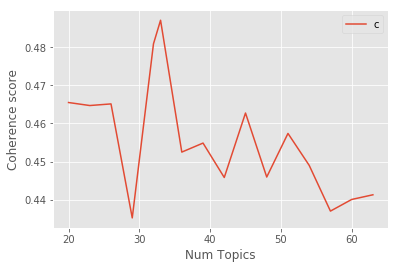

In [219]:
plt.plot(xnew, c_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
coherence_list_df = pd.DataFrame(
    {'num_topics': xnew,
     'coherence_values': c_values,
    })
coherence_list_df

writer = pd.ExcelWriter('coherence_list_df.xlsx')
coherence_list_df.to_excel(writer, sheet_name='coherence_list_df')
writer.save()



In [209]:
l_model = model_list[4]
topicnames = ["Topic" + str(i) for i in range(l_model.num_topics)]
# index names
docnames = ["Doc" + str(i) for i in range(len(data))]
all_topics = l_model.get_document_topics(corpus)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_numpy = np.round(all_topics_numpy, 2)
# Make the pandas dataframe
df_document_topic = pd.DataFrame(all_topics_numpy, columns=topicnames, index=docnames)
df_document_topic.head()


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,Topic30,Topic31
Doc0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.22,0.0,0.0,0.12,0.0,0.0,0.00,0.0,0.00,0.00
Doc1,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.00,0.0,0.0,0.22,0.0,0.0,0.00,0.0,0.00,0.00
Doc2,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.00,0.0,0.0,0.97,0.0,0.0,0.02,0.0,0.00,0.00
Doc3,0.00,0.1,0.0,0.16,0.10,0.0,0.0,0.00,0.0,0.08,...,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.42,0.00
Doc4,0.06,0.0,0.0,0.00,0.18,0.0,0.0,0.12,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.05


In [213]:
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
#df_document_topics.head()
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,Topic30,Topic31,dominant_topic
Doc0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.64,0,0,0.01,0,0,0,0.22,0,0,0.12,0,0,0,0,0,0,15
Doc1,0,0,0,0,0,0,0,0,0,0,0,0,0.16,0,0,0.6,0,0,0,0,0,0,0,0,0,0.22,0,0,0,0,0,0,15
Doc2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.97,0,0,0.02,0,0,0,25
Doc3,0,0.1,0,0.16,0.1,0,0,0,0,0.08,0,0,0.13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.42,0,30
Doc4,0.06,0,0,0,0.18,0,0,0.12,0,0,0,0,0,0,0,0.17,0,0,0,0,0,0.41,0,0,0,0,0,0,0,0,0,0.05,21
Doc5,0,0,0.15,0,0.14,0,0,0,0,0,0,0.09,0,0,0,0,0,0,0,0,0,0,0.16,0,0,0.46,0,0,0,0,0,0,25
Doc6,0,0,0,0,0,0,0,0,0,0,0,0,0,0.24,0,0,0,0,0,0,0,0,0,0,0,0.52,0,0.23,0,0,0,0,25
Doc7,0,0,0,0,0.41,0,0,0,0,0,0,0,0,0.03,0,0.25,0,0,0,0,0,0,0,0,0,0.12,0,0,0,0.07,0,0.12,4
Doc8,0,0,0,0,0,0.09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.84,0,0,0.06,0,0,0,0,0,0,22
Doc9,0.82,0,0,0,0.06,0,0,0,0,0,0,0,0.08,0,0,0,0,0,0,0,0,0,0,0,0,0,0.03,0,0,0,0,0,0


In [224]:
## saving the lda model
print (l_model)
l_model.save('lda.model_32_topics')
model =  LdaModel.load('lda.model_32_topics')
print(model)

LdaModel(num_terms=64430, num_topics=32, decay=0.5, chunksize=2000)


In [ ]:
## irrelevant code


n_gram_dict  = pd.read_excel('terms_for_n_grams.xlsx')
n_gram_dict.head()
n_gram_words = n_gram_dict.terms.tolist()
item = 0
while item < 3:
    print(n_gram_words[item])
    item = item+1


global adj_word_collection
global row_count
adj_word_collection = []
row_count = 0 

for index, row in news_df.iterrows():
    text = row["newsbody_lda"]
    list_words_of_corpus =text.split()
    for pos, word in enumerate(list_words_of_corpus): 
        if word in n_gram_words :
            if pos+1 < len (list_words_of_corpus ):
                term_1 = list_words_of_corpus[pos+1]
                bi_gram = word + '_' + term_1
                adj_word_collection.append(dict(key = word, bi_gram = bi_gram)) 


word_collections = pd.DataFrame (adj_word_collection )
word_collections.head()

writer = pd.ExcelWriter('word_collections.xlsx', engine='xlsxwriter',options={'strings_to_urls': False})
word_collections_01.to_excel(writer)
writer.save()
writer.close()


word_collections['count'] =word_collections.groupby(['bi_gram'])['key'].transform('count')
word_collections.head()
word_collections.drop_duplicates(inplace=True)
print(len(word_collections))
word_collections['count'].describe()

